In [3]:
import tensorflow as tf
from tensorflow.keras import layers, Model
import numpy as np
import cv2
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [4]:
import os
import numpy as np
from PIL import Image
import csv
import pandas as pd
from sklearn.model_selection import train_test_split

# Define folder paths
folder1_path = '/kaggle/input/rock-fractures/Original Images'
folder2_path = '/kaggle/input/rock-fractures/Edge Masks'
patched_folder_path = '/kaggle/working/patched_images'
overlay_folder_path = '/kaggle/working/overlay_images'

# Define output CSV paths
patch_pairs_csv_path = '/kaggle/working/patch_pairs.csv'
train_csv_path = '/kaggle/working/train.csv'
val_csv_path = '/kaggle/working/validation.csv'
test_csv_path = '/kaggle/working/test.csv'

# Create output directories if they don't exist
os.makedirs(patched_folder_path, exist_ok=True)
os.makedirs(overlay_folder_path, exist_ok=True)

# --- Function Definitions (No changes needed here) ---

def convert_images_to_png(folder_path):
    for filename in os.listdir(folder_path):
        if not filename.lower().endswith('.png'):
            file_path = os.path.join(folder_path, filename)
            with Image.open(file_path) as img:
                png_filename = f"{os.path.splitext(filename)[0]}.png"
                png_path = os.path.join(folder_path, png_filename)
                img.save(png_path)
            os.remove(file_path)
            print(f"Converted {filename} to {png_filename} and removed the original file.")

def validate_image_pairs(folder1_path, folder2_path):
    folder1_images = os.listdir(folder1_path)
    folder2_images = os.listdir(folder2_path)
    valid_pairs = []
    for image_name in folder1_images:
        if image_name in folder2_images:
            image1 = Image.open(os.path.join(folder1_path, image_name))
            image2 = Image.open(os.path.join(folder2_path, image_name))
            if image1.size == image2.size:
                valid_pairs.append(image_name)
    print(f"Found {len(valid_pairs)} valid image pairs.")
    return valid_pairs

def convert_to_binary_mask(image):
    image_array = np.array(image.convert('L'))
    binary_mask = (image_array > 0).astype(np.uint8) * 255
    return Image.fromarray(binary_mask)

def create_overlay(original_patch, binary_mask_patch):
    original_array = np.array(original_patch)
    binary_mask_array = np.array(binary_mask_patch)
    overlay = original_array.copy()
    red_channel = overlay[:, :, 0]
    red_channel[binary_mask_array > 0] = 255
    overlay[:, :, 0] = red_channel
    return Image.fromarray(overlay)

def create_patches(image_pairs, folder1_path, folder2_path, patched_folder_path, overlay_folder_path, csv_file_path, patch_size=224, min_white_pixel_ratio=0.01):
    total_patches = 0
    saved_patches = 0
    with open(csv_file_path, 'w', newline='') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(['Original Image Patch', 'Binary Mask Image Patch'])
        for image_name in image_pairs:
            original_image = Image.open(os.path.join(folder1_path, image_name))
            binary_mask_image = convert_to_binary_mask(Image.open(os.path.join(folder2_path, image_name)))
            original_array = np.array(original_image)
            binary_mask_array = np.array(binary_mask_image)
            height, width = original_array.shape[:2]
            patch_number = 0
            image_total_patches = 0
            image_saved_patches = 0
            for i in range(0, height, patch_size):
                for j in range(0, width, patch_size):
                    image_total_patches += 1
                    original_patch = original_array[i:i+patch_size, j:j+patch_size]
                    binary_mask_patch = binary_mask_array[i:i+patch_size, j:j+patch_size]
                    if original_patch.shape[0] != patch_size or original_patch.shape[1] != patch_size:
                        continue
                    edge_pixel_count = np.sum(binary_mask_patch > 0)
                    total_pixel_count = patch_size * patch_size
                    if edge_pixel_count / total_pixel_count < min_white_pixel_ratio:
                        continue
                    original_patch_img = Image.fromarray(original_patch)
                    binary_mask_patch_img = Image.fromarray(binary_mask_patch)
                    original_patch_name = f"{image_name.split('.')[0]}_original_patch{patch_number}.png"
                    binary_mask_patch_name = f"{image_name.split('.')[0]}_binarymask_patch{patch_number}.png"
                    original_patch_img.save(os.path.join(patched_folder_path, original_patch_name))
                    binary_mask_patch_img.save(os.path.join(patched_folder_path, binary_mask_patch_name))
                    overlay_img = create_overlay(original_patch_img, binary_mask_patch_img)
                    overlay_name = f"{image_name.split('.')[0]}_overlay_patch{patch_number}.png"
                    overlay_img.save(os.path.join(overlay_folder_path, overlay_name))
                    csv_writer.writerow([os.path.join(patched_folder_path, original_patch_name), os.path.join(patched_folder_path, binary_mask_patch_name)])
                    patch_number += 1
                    image_saved_patches += 1
            print(f"Processed {image_name}: made {image_total_patches} patches, retained {image_saved_patches} patches.")
            total_patches += image_total_patches
            saved_patches += image_saved_patches
    print(f"Total patches processed: {total_patches}")
    print(f"Total patches saved: {saved_patches}")


# --- Main Execution Logic with Check ---

# Check if the final output files already exist.
if not (os.path.exists(train_csv_path) and os.path.exists(val_csv_path) and os.path.exists(test_csv_path)):
    print("Train/validation/test CSV files not found. Starting data preparation process...")

    # Step 1: Process the images and create patches
    print("Converting non-PNG images to PNG...")
    convert_images_to_png(folder1_path)
    convert_images_to_png(folder2_path)
    print("All files are PNG")

    print("Validating image pairs...")
    valid_image_pairs = validate_image_pairs(folder1_path, folder2_path)

    print("Creating patches...")
    create_patches(valid_image_pairs, folder1_path, folder2_path, patched_folder_path, overlay_folder_path, patch_pairs_csv_path)

    # Step 2: Load the patch pairs CSV file
    patch_pairs_df = pd.read_csv(patch_pairs_csv_path)

    # Step 3: Shuffle the dataframe
    print("Shuffling data...")
    patch_pairs_df = patch_pairs_df.sample(frac=1).reset_index(drop=True)

    # Step 4: Calculate the number of samples for each split
    total_samples = len(patch_pairs_df)
    train_size = int(total_samples * 0.5)
    val_test_size = total_samples - train_size
    val_size = int(val_test_size * 0.5)
    test_size = val_test_size - val_size

    # Step 5: Split the dataframe
    print("Splitting data into train, validation, and test sets...")
    train_df, val_test_df = train_test_split(patch_pairs_df, train_size=train_size, random_state=42)
    val_df, test_df = train_test_split(val_test_df, test_size=test_size, random_state=42)

    # Step 6: Save the splits into separate CSV files
    train_df.to_csv(train_csv_path, index=False)
    val_df.to_csv(val_csv_path, index=False)
    test_df.to_csv(test_csv_path, index=False)

    print(f"Training set size: {len(train_df)}")
    print(f"Validation set size: {len(val_df)}")
    print(f"Test set size: {len(test_df)}")

    print("All tasks completed successfully.")

else:
    print("Train, validation, and test CSV files already exist. Skipping data preparation.")

Train/validation/test CSV files not found. Starting data preparation process...
Converting non-PNG images to PNG...
All files are PNG
Validating image pairs...
Found 49 valid image pairs.
Creating patches...
Processed DSC00888.png: made 330 patches, retained 54 patches.
Processed 0V5A3736.png: made 1014 patches, retained 690 patches.
Processed DJI_0226.png: made 425 patches, retained 312 patches.
Processed DJI_0022.png: made 425 patches, retained 214 patches.
Processed DJI_0034.png: made 425 patches, retained 205 patches.
Processed DJI_0404.png: made 425 patches, retained 268 patches.
Processed DJI_0796.png: made 425 patches, retained 278 patches.
Processed DJI_0065.png: made 391 patches, retained 249 patches.
Processed DJI_0050.png: made 425 patches, retained 253 patches.
Processed DJI_0443.png: made 425 patches, retained 160 patches.
Processed DJI_0997.png: made 425 patches, retained 190 patches.
Processed DSC_5053.png: made 414 patches, retained 247 patches.
Processed DSC_5049.png: 

In [17]:
csv_path = "/kaggle/working/train.csv"

In [18]:
df = pd.read_csv(csv_path)
df.head()

,Original Image Patch,Binary Mask Image Patch
0,/kaggle/working/patched_images/DJI_0011_origin...,/kaggle/working/patched_images/DJI_0011_binary...
1,/kaggle/working/patched_images/DJI_0796_origin...,/kaggle/working/patched_images/DJI_0796_binary...
2,/kaggle/working/patched_images/DJI_0022_origin...,/kaggle/working/patched_images/DJI_0022_binary...
3,/kaggle/working/patched_images/0V5A4035_origin...,/kaggle/working/patched_images/0V5A4035_binary...
4,/kaggle/working/patched_images/DJI_0194_origin...,/kaggle/working/patched_images/DJI_0194_binary...


In [19]:
# Function to load images
def load_image(image_path, mask_path, size=(224, 224)):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, size)
    mask = cv2.resize(mask, size)
    image = image / 255.0  # Normalize
    mask = mask / 255.0  # Normalize
    mask = np.expand_dims(mask, axis=-1)  # Add channel dimension
    return image, mask

In [20]:
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd

class RockFractureDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with image paths.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        # Get the image and mask paths from the dataframe
        img_path = self.data_frame.iloc[idx, 0]
        mask_path = self.data_frame.iloc[idx, 1]

        # Load the image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("L") # 'L' for grayscale

        # Apply transformations if any
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

In [21]:
import torchvision.transforms as transforms

# Define paths to your CSV files
train_csv_path = '/kaggle/working/train.csv'
val_csv_path = '/kaggle/working/validation.csv'

# Define your transformations (e.g., resize, convert to tensor, normalize)
# Note: You'll likely need more complex transformations
data_transform = transforms.Compose([
    transforms.ToTensor(),
    # Add other transforms like normalization if needed
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create Dataset instances
train_dataset = RockFractureDataset(csv_file=train_csv_path, transform=data_transform)
val_dataset = RockFractureDataset(csv_file=val_csv_path, transform=data_transform)

# Create DataLoader instances
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# You can now iterate over the DataLoader in your training loop
# Example of getting one batch:
images, masks = next(iter(train_loader))

print(f"Batch of images shape: {images.shape}") # e.g., torch.Size([16, 3, 224, 224])
print(f"Batch of masks shape: {masks.shape}")   # e.g., torch.Size([16, 1, 224, 224])

Batch of images shape: torch.Size([16, 3, 224, 224])
Batch of masks shape: torch.Size([16, 1, 224, 224])


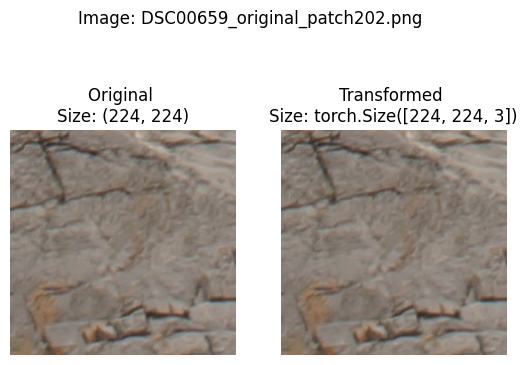

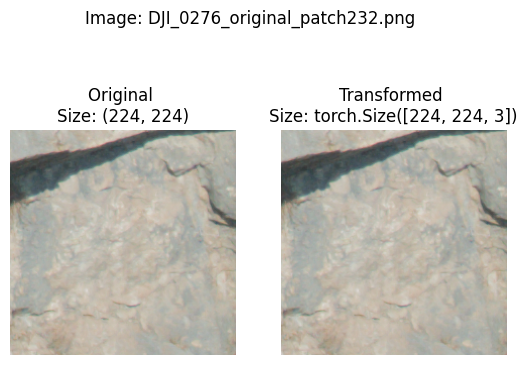

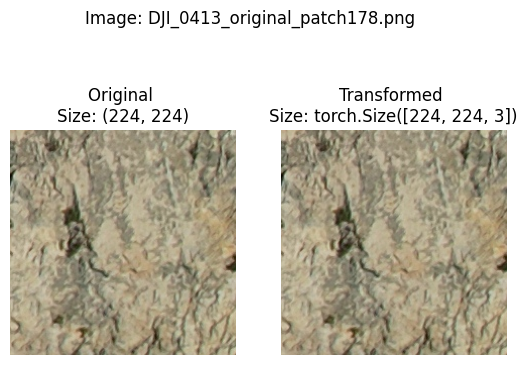

In [22]:
import random
from PIL import Image
import pandas as pd
import matplotlib.pyplot as plt
import os
import torchvision.transforms as transforms # Assuming you have this defined

# --- Your function (with a small fix for the title) ---
def plot_transformed_images(image_paths, transform, n=3, seed=32):
    """Plots a series of random images from image_paths."""
    random.seed(seed)
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f)
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            transformed_image = transform(f).permute(1, 2, 0)
            ax[1].imshow(transformed_image)
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")
            
            # --- FIX for the title ---
            # Get just the filename instead of trying to find a parent directory class
            fig.suptitle(f"Image: {os.path.basename(image_path)}", fontsize=12)


# --- FIX for the function call ---
# 1. Load the CSV file
train_csv_path = '/kaggle/working/train.csv'
train_df = pd.read_csv(train_csv_path)

# 2. Get the list of image paths from the first column
train_image_paths = train_df.iloc[:, 0].tolist()

# 3. Pass the LIST to the function
plot_transformed_images(image_paths=train_image_paths,
                        transform=data_transform,
                        n=3)

In [23]:
train_loader, val_loader

(<torch.utils.data.dataloader.DataLoader at 0x7a91a07221d0>,
 <torch.utils.data.dataloader.DataLoader at 0x7a91a0719f90>)

In [24]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        # Contracting Path (Encoder)
        self.inc = DoubleConv(in_channels, 64)
        self.down1 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(64, 128))
        self.down2 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(128, 256))
        self.down3 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(256, 512))
        self.down4 = nn.Sequential(nn.MaxPool2d(2), DoubleConv(512, 1024))

        # Expansive Path (Decoder)
        self.up1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv1 = DoubleConv(1024, 512)
        
        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv2 = DoubleConv(512, 256)
        
        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv3 = DoubleConv(256, 128)
        
        self.up4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv4 = DoubleConv(128, 64)

        # Final Convolution
        self.outc = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)

        # Decoder with skip connections
        up_x1 = self.up1(x5)
        # Handle potential size mismatch from pooling
        if up_x1.shape != x4.shape:
            up_x1 = TF.resize(up_x1, size=x4.shape[2:])
        concat1 = torch.cat([x4, up_x1], dim=1)
        dec_x1 = self.conv1(concat1)

        up_x2 = self.up2(dec_x1)
        if up_x2.shape != x3.shape:
            up_x2 = TF.resize(up_x2, size=x3.shape[2:])
        concat2 = torch.cat([x3, up_x2], dim=1)
        dec_x2 = self.conv2(concat2)

        up_x3 = self.up3(dec_x2)
        if up_x3.shape != x2.shape:
            up_x3 = TF.resize(up_x3, size=x2.shape[2:])
        concat3 = torch.cat([x2, up_x3], dim=1)
        dec_x3 = self.conv3(concat3)

        up_x4 = self.up4(dec_x3)
        if up_x4.shape != x1.shape:
            up_x4 = TF.resize(up_x4, size=x1.shape[2:])
        concat4 = torch.cat([x1, up_x4], dim=1)
        dec_x4 = self.conv4(concat4)

        # Final output
        logits = self.outc(dec_x4)
        return logits

In [25]:
# Example Usage
if __name__ == '__main__':
    # Define model parameters
    input_channels = 3  # For RGB images
    output_channels = 1 # For binary segmentation (one mask)
    
    # Instantiate the model
    model = UNet(in_channels=input_channels, out_channels=output_channels)
    
    # Create a dummy input tensor
    # Batch size = 1, Channels = 3, Height = 224, Width = 224
    dummy_input = torch.randn(1, 3, 224, 224)
    
    # Pass the input through the model
    output = model(dummy_input)
    
    # Print the shapes
    print(f"Input shape: {dummy_input.shape}")
    print(f"Output shape: {output.shape}")

    # Check if input and output shapes (H, W) are the same
    assert dummy_input.shape[2:] == output.shape[2:], "Height and Width of input and output must match"

Input shape: torch.Size([1, 3, 224, 224])
Output shape: torch.Size([1, 1, 224, 224])


In [26]:
import torch
import torch.nn as nn

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: str):
    """Performs a single training step, updating model weights."""
    model.train()
    train_loss, train_dice = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.float().to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate and accumulate Dice score
        preds_prob = torch.sigmoid(y_pred)
        preds_binary = (preds_prob > 0.5).float()
        dice = (2 * (preds_binary * y).sum()) / ((preds_binary + y).sum() + 1e-8)
        train_dice += dice.item()

    # Calculate average loss and Dice score per batch
    train_loss /= len(dataloader)
    train_dice /= len(dataloader)
    return train_loss, train_dice

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: str):
    """Performs a single evaluation step on a test or validation set."""
    model.eval()
    test_loss, test_dice = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.float().to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate Dice score
            preds_prob = torch.sigmoid(test_pred_logits)
            preds_binary = (preds_prob > 0.5).float()
            dice = (2 * (preds_binary * y).sum()) / ((preds_binary + y).sum() + 1e-8)
            test_dice += dice.item()

    # Calculate average loss and Dice score per batch
    test_loss /= len(dataloader)
    test_dice /= len(dataloader)
    return test_loss, test_dice

In [27]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: str):
    """The main training and testing loop."""
    results = {
        "train_loss": [],
        "train_dice": [],
        "test_loss": [],
        "test_dice": []
    }

    for epoch in tqdm(range(epochs)):
        train_loss, train_dice = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        test_loss, test_dice = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            device=device
        )

        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_dice: {train_dice:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_dice: {test_dice:.4f}"
        )

        results["train_loss"].append(train_loss)
        results["train_dice"].append(train_dice)
        results["test_loss"].append(test_loss)
        results["test_dice"].append(test_dice)

    return results

In [29]:
import torch.optim as optim

# Setup device, model, and dataloaders
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model = UNet(in_channels=3, out_channels=1).to(DEVICE)
# train_loader = ...
# val_loader = ...

# Hyperparameters
LEARNING_RATE = 1e-4
EPOCHS = 5

# Setup loss function and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Start training
training_results = train(
    model=model,
    train_dataloader=train_loader,
    test_dataloader=val_loader, # Using validation set for testing step
    optimizer=optimizer,
    loss_fn=loss_fn,
    epochs=EPOCHS,
    device=DEVICE
)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.3269 | train_dice: 0.4119 | test_loss: 0.2230 | test_dice: 0.6791
Epoch: 2 | train_loss: 0.1777 | train_dice: 0.7309 | test_loss: 0.1489 | test_dice: 0.7356
Epoch: 3 | train_loss: 0.1173 | train_dice: 0.7739 | test_loss: 0.1009 | test_dice: 0.8017
Epoch: 4 | train_loss: 0.0873 | train_dice: 0.7946 | test_loss: 0.0728 | test_dice: 0.8195
Epoch: 5 | train_loss: 0.0711 | train_dice: 0.8071 | test_loss: 0.0608 | test_dice: 0.8379


In [30]:
import torch

# Define the save path within the Kaggle working directory
MODEL_SAVE_PATH = "/kaggle/working/unet_model.pth"

# Save the model's state dictionary
torch.save(model.state_dict(), MODEL_SAVE_PATH)

print(f"Model saved to: {MODEL_SAVE_PATH}")

Model saved to: /kaggle/working/unet_model.pth


In [ ]:
import torch
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import pandas as pd
import random
import os

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "unet_model.pth"       # Path to your saved model
CSV_FILE_PATH = "/kaggle/working/test.csv"   # Path to your CSV file
IMAGE_PATH_COLUMN = "Original Image Patch"    # The name of the column with the image paths

# --- Step 1: Select a random image path from the CSV ---

df = pd.read_csv(CSV_FILE_PATH)
image_paths = df[IMAGE_PATH_COLUMN].tolist()
image_path = random.choice(image_paths)

print(f"Randomly selected image: {image_path}")

# --- Step 2: Load the trained model ---

# Make sure your UNet class definition is available
# from model import UNet

model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))
model.to(DEVICE)
model.eval()
print("Model loaded and in evaluation mode.")

# --- Step 3: Define transformations and load the image ---

transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

original_image = Image.open(image_path).convert("RGB")
image_np = np.array(original_image)
input_image = transform(image=image_np)["image"]
input_image = input_image.unsqueeze(0).to(DEVICE)

# --- Step 4: Make a prediction ---

print("Making prediction...")
with torch.no_grad():
    pred_logits = model(input_image)
    pred_probs = torch.sigmoid(pred_logits)
    pred_mask = (pred_probs > 0.5).float()

# --- Step 5: Prepare images for visualization ---

# Convert tensors to NumPy arrays for plotting
output_probs = pred_probs.squeeze().cpu().numpy()
output_mask = pred_mask.squeeze().cpu().numpy()

# Get the base name of the file for the title
image_filename = os.path.basename(image_path)

# --- Step 6: Visualize all three images ---

print("Displaying results...")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Display the original image
ax1.imshow(original_image)
ax1.set_title(f"Original Image:\n{image_filename}")
ax1.axis("off")

# Display the predicted probabilities
ax2.imshow(output_probs, cmap='gray')
ax2.set_title("Predicted Probabilities")
ax2.axis("off")

# Display the final binary mask
ax3.imshow(output_mask, cmap='gray')
ax3.set_title("Final Binary Mask (Threshold > 0.5)")
ax3.axis("off")

plt.show()

In [ ]:
import torch
from PIL import Image
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import requests
import io

# --- Configuration ---
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MODEL_PATH = "unet_model.pth"       # Path to your saved model

# URL of the fracture image you want to test
IMAGE_URL = "https://media.sciencephoto.com/c0/12/00/19/c0120019-800px-wm.jpg" # Example X-ray image URL

# --- Step 1: Download the image from the URL ---

try:
    response = requests.get(IMAGE_URL)
    response.raise_for_status() # Raise an exception for bad status codes
    image_bytes = io.BytesIO(response.content)
    original_image = Image.open(image_bytes).convert("RGB")
    print(f"Successfully downloaded image from URL.")
except requests.exceptions.RequestException as e:
    print(f"Error downloading image: {e}")
    exit()

# --- Step 2: Load the trained model ---

# Make sure your UNet class definition is available
# from model import UNet

model = UNet(in_channels=3, out_channels=1)
model.load_state_dict(torch.load(MODEL_PATH, map_location=torch.device(DEVICE)))
model.to(DEVICE)
model.eval()
print("Model loaded and in evaluation mode.")

# --- Step 3: Define transformations and preprocess the image ---

transform = A.Compose([
    A.Resize(height=256, width=256),
    A.Normalize(
        mean=[0.0, 0.0, 0.0],
        std=[1.0, 1.0, 1.0],
        max_pixel_value=255.0,
    ),
    ToTensorV2(),
])

image_np = np.array(original_image)
input_image = transform(image=image_np)["image"]
input_image = input_image.unsqueeze(0).to(DEVICE)

# --- Step 4: Make a prediction ---

print("Making prediction...")
with torch.no_grad():
    pred_logits = model(input_image)
    pred_probs = torch.sigmoid(pred_logits)
    pred_mask = (pred_probs > 0.5).float()

# --- Step 5: Visualize the results ---

output_probs = pred_probs.squeeze().cpu().numpy()
output_mask = pred_mask.squeeze().cpu().numpy()

print("Displaying results...")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

ax1.imshow(original_image)
ax1.set_title("Original Image (from URL)")
ax1.axis("off")

ax2.imshow(output_probs, cmap='gray')
ax2.set_title("Predicted Probabilities")
ax2.axis("off")

ax3.imshow(output_mask, cmap='gray')
ax3.set_title("Final Binary Mask")
ax3.axis("off")

plt.show()